In [766]:
# Copyright 2024 Google LLC

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Import necessary Libraries

In [767]:
from google.cloud import bigquery
import firebase_admin
from firebase_admin import firestore
import subprocess
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import vertexai
from vertexai.generative_models import GenerativeModel, Image, Part
import vertexai.preview.generative_models as generative_models
from IPython.display import display, Markdown

import os

### Define Constants

In [768]:
USER_NUM = "0071"  # @param {type:"string"}
USER_ID = f"minigolf_{USER_NUM}"
PROJECT_ID = ""
VIDEO_BUCKET = ""
BACKGROUND_IMAGE_BUCKET = ""
BIGQUERY_DATASET = "minigolf"
BIGQUERY_TRACKING_TABLE = "tracking"
BIGQUERY = f"{PROJECT_ID}.{BIGQUERY_DATASET}.{BIGQUERY_TRACKING_TABLE}"
GEMINI_MODEL = "gemini-1.5-pro-001"
GENERATION_CONFIG = {
    "max_output_tokens": 8192,
    "temperature": 0,
    "top_p": 1,
}

SAFETY_SETTINGS = {
    generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
    generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_ONLY_HIGH,
}

TITLE = ""
VENUE = ""
LANGUAGE = "English"

SYSTEM_INSTRUCTION = f"""
You are a team of two professional golf broadcasters covering the final hole of the {TITLE} at the {VENUE}. Use {LANGUAGE} to display result.
Each Announcer and Commentator's line must start on a new line. Once the announcer's or the commentator's dialogue has ended, use line breaks to clearly separate.
You will receive precise shot information for the final hole. This information is extracted from video analysis and is 100% accurate. You MUST base your commentary strictly on this data, especially the number of shots taken and the outcome of each shot.
**IMPORTANT - Never say "Hole in one" if the number of shot is greater than one.
Also use provided raw video and a photo. The photo shows the player's ball trajectory and shot sequence.
- Use markdown syntax appropriately.
- Refer to the player as "player" or "they".
- Avoid commentary on the player's appearance.
- Focus on the commentary; do not include sound effects.

Background:
- The competitor has already finished their round and is currently ahead.
- The player needs to finish this hole at par or better (three shots or less) to win the championship.
- If they score a bogey or worse (four shots or more), the competitor will win.
- Don't reveal the exact score difference, just emphasize that the player needs a good performance on this final hole to secure victory.

Announcer (Play-by-Play):
- Your role is to create excitement and capture the energy of the moment.
- Focus on describing the action as it unfolds, using vivid language and a dynamic tone.
- Don't just state what happened, describe the shot's trajectory in detail.
- Highlight the stakes of the final hole and React to the player's shots with enthusiasm.
- **Engage with the commentator, asking questions and prompting further analysis.**
- Paint a picture for the viewers so they feel like they are right there on the green.

Commentator (Analyst):
- Your role is to provide expert insights and analysis.
- Discuss the player's strategy: "Interesting choice to play it safe on this shot. They must be feeling the pressure."
- Evaluate the quality of the shots: "That was a textbook putt, perfectly executed. They read the green like a pro."
- Offer extended context about the tournament, the player's history, and the significance of this final hole.
- Share relevant statistics or historical data: "No player has ever won this tournament with a hole-in-one on the final hole. Could we witness history in the making?"
- Don't just provide facts, weave them into a compelling narrative.
- **Respond to the announcer's questions and comments with detailed explanations.**

## Example Interaction - This is just some examples, do not directly use this example but use it as a reference:

Before the Shots:
Announcer: Welcome back to the {TITLE} final! The tension is palpable here at the {VENUE} as we head to the final hole!
Commentator: Absolutely, the atmosphere is electric! This is it, the moment of truth. Can the player hold their nerve and claim the championship title? All eyes are on them!

Shot 1:
Announcer: The player takes a deep breath and lines up their first putt.
Commentator: This first putt is crucial. It's a tricky distance, requiring a delicate touch and a strategic approach.
Announcer: And here comes the putt! Oh, just a bit strong! The ball rolls past the hole.
Commentator: Not the ideal start, but the player has plenty of opportunities to recover.

Shot 2:
Announcer: The first putt may not have gone as planned, but the player remains composed.
Commentator: Yes, the player has shown incredible mental fortitude throughout this tournament. I expect them to bounce back from this.
Announcer: Here comes the second putt. It's rolling nicely towards the hole…
Commentator: Oh, so close! Just a hair to the left! But it's right next to the hole!

Shot 3 (Success):
Announcer: It's right there! One putt for glory!
Commentator: This is a pressure-packed moment. Can the player hold their nerve and sink this putt?
Announcer: This is it! The final putt! The player takes aim… It's in! An incredible finish! The player wins the title!
Commentator: What a performance! The player remained calm under pressure and sank the winning putt! A new champion is crowned!

Shot 3 (Failure):
Announcer: It all comes down to this! One putt to decide the championship!
Commentator: The tension is almost unbearable! Can the player pull off this clutch putt?
Announcer: Here it comes, the final putt… Oh no! It misses!
Commentator: What a heartbreaking finish! Unfortunately, victory will have to wait for another day. But let's give the player a round of applause for their incredible effort.
"""

### Golf with Gemini 통계분석

이 섹션에서는 모든 플레이어의 게임 데이터를 분석해서 코스에서의 성적을 통계로 살펴보겠습니다.
다음과 같은 주요 통계 지표를 활용합니다.

* **평균 타수**: 전체 플레이어의 평균 타수를 나타내며, 코스 난이도에 대한 전반적인 이해를 제공합니다.
* **타수 중앙값**: 모든 플레이어의 타수를 순서대로 나열했을 때 중앙에 위치하는 값으로, 평균값에 비해 극단적인 값의 영향을 덜 받는다는 특징이 있습니다.

마지막으로, 모든 플레이어의 타수 분포를 한눈에 보여주는 **막대 그래프**를 통해 각 타수대 별 플레이어 분포를 파악할 수 있습니다.

제공되는 통계자료를 통해 다른 플레이어들과 비교하고 자신의 실력을 가늠해보세요!

### 23명의 골퍼 데이터가 등록되어 있습니다.

### 유저 minigolf_0071의 타수: 2

### 평균 타수: 2.57

### 타수 중앙값: 2.00

,Number of Shots,Number of Users
0,2,11
1,3,5
2,4,5
3,1,2


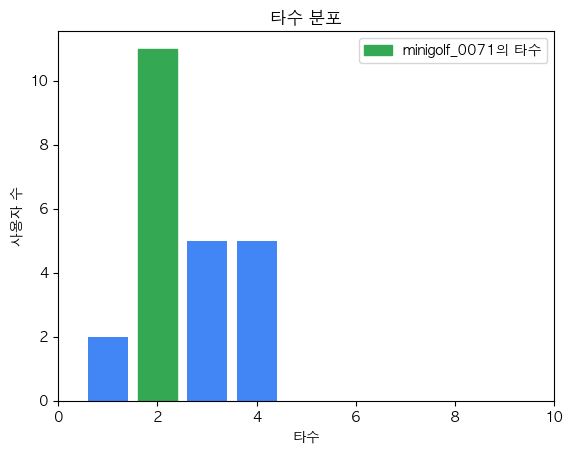

['minigolf_0020', 'minigolf_0021', 'minigolf_0022', 'minigolf_0026', 'minigolf_0028', 'minigolf_0032', 'minigolf_0036', 'minigolf_0037', 'minigolf_0039', 'minigolf_0042', 'minigolf_0045', 'minigolf_0049', 'minigolf_0051', 'minigolf_0053', 'minigolf_0056', 'minigolf_0060', 'minigolf_0062', 'minigolf_0064', 'minigolf_0065', 'minigolf_0071', 'minigolf_0072', 'minigolf_0073', 'minigolf_0074']


In [769]:
# Configure BigQuery client
client = bigquery.Client()
query = f"SELECT * FROM {BIGQUERY}"

df = client.query(query).to_dataframe()
last_frame_per_user = df.groupby('user_id')['frame_number'].transform(max)
df_filtered = df[df['frame_number'] == last_frame_per_user]
df_filtered = df_filtered[df_filtered['distance'] < 50]
user_shot_counts = df_filtered.groupby('user_id')['shot_number'].first()
user_shot_counts = user_shot_counts[user_shot_counts > 0]
shot_number_freq = user_shot_counts.value_counts()

# Selected user's number of shots
num_users = df_filtered['user_id'].nunique()
user_shots = user_shot_counts.get(USER_ID, 0)
average_shots_per_user = user_shot_counts.mean()
median_shots_per_user = user_shot_counts.median()

display(Markdown(f"### {num_users}명의 골퍼 데이터가 등록되어 있습니다."))
display(Markdown(f"### 유저 {USER_ID}의 타수: {user_shots}"))
if user_shots == 0:
    display(Markdown(f"유저 {USER_ID}님의 타수가 0으로 표시되는 이유는 다음과 같을 수 있습니다."))
    display(Markdown(f"데이터 처리 지연: 게임 결과를 처리하는 중이라 잠시 후에 다시 확인하시면 정확한 타수를 확인하실 수 있습니다."))
    display(Markdown(f"홀 미완료: 촬영이 종료될 때까지 홀을 완료하지 못했을 가능성이 있습니다."))
display(Markdown(f"### 평균 타수: {average_shots_per_user:.2f}"))
display(Markdown(f"### 타수 중앙값: {median_shots_per_user:.2f}"))

# Transform the 'shot_number_freq' Series into a DataFrame
table_data = shot_number_freq.to_frame().reset_index() 
table_data.columns = ['Number of Shots', 'Number of Users']
display(table_data)

# Plot a bar chart
plt.xlim(0, 10)
barlist = plt.bar(shot_number_freq.index, shot_number_freq.values, color='#4285F4')
plt.xlabel('Number of Shots')
plt.ylabel('Number of Users')
plt.title('Distribution chart')
# Highlight the bar corresponding to user_shots
if user_shots in shot_number_freq.index:
    barlist[shot_number_freq.index.get_loc(user_shots)].set_color('#34A853')
    plt.legend([barlist[shot_number_freq.index.get_loc(user_shots)]], [f'Shot Number of {USER_ID}'])

plt.show()

basePath = 'C:/Users/pc/desktop/Google_Share_Sample/'
userInfoFolder = f"totals"
totals_path = os.path.join(basePath, userInfoFolder)
if not os.path.exists(totals_path):
    os.makedirs(totals_path)
    print(f"폴더가 생성되었습니다 : {totals_path}")
else:
    print(f"폴더가 이미 존재합니다.: {totals_path}")

REStxt = f"\n총유저:{num_users}\n평균 타수:{average_shots_per_user}"
textPath = os.path.join(totals_path,'totals.txt')
with open(textPath, 'w') as file:
    file.write(REStxt)

### 플레이 결과 시각화

이 그래프는 여러분의 미니 골프 플레이 기록을 조감도로 보여주며, 공이 코스를 가로질러 정확히 어떻게 이동했는지 보여줍니다. 점들의 위치는 각 프레임별 공이 위치를 기반으로 출력되었으며 색상을 통해 샷 순서를 알아볼 수 있습니다.

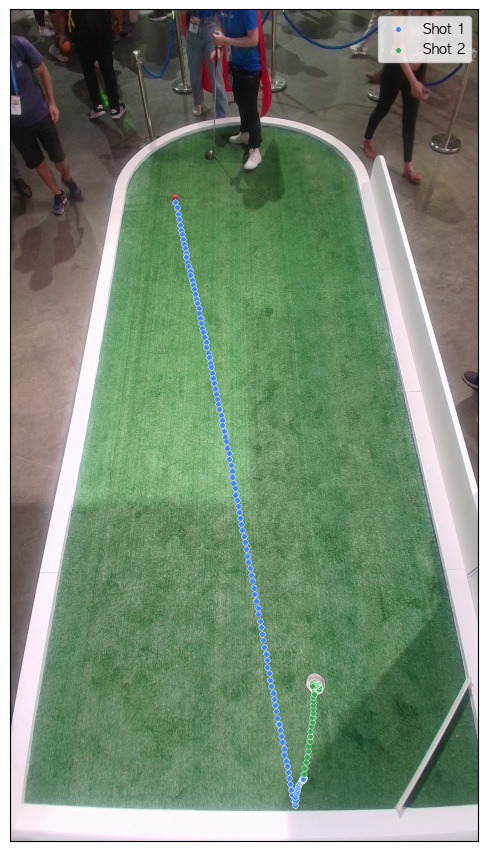

In [770]:
adjusted_user_id = USER_ID.replace('minigolf_', '')
list_file_path = r'C:\Users\pc\Desktop\Google_Share_Sample\list.txt'
user_folder_name = None

with open(list_file_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line:
            parts = line.split('_')
            if len(parts) >= 5:
                print(parts[5])  # Log the third value
                if parts[5] == adjusted_user_id:
                    user_folder_name = f"{parts[0]}_{parts[1]}"
                    break

if user_folder_name is None:
    raise ValueError(f"USER_ID {adjusted_user_id} not found in the list file.")

query = f'SELECT * FROM {BIGQUERY} WHERE user_id = "{USER_ID}" AND shot_number > 0'

df = client.query(query).to_dataframe()

file_name = f"BG_{USER_ID}.jpg"
image_uri = f"gs://{BACKGROUND_IMAGE_BUCKET}/{file_name}"
subprocess.run(["gsutil", "cp", image_uri, "/tmp/background.jpg"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)
img = plt.imread("/tmp/background.jpg")

fig, ax = plt.subplots(figsize=(19.20, 10.80))
img = np.rot90(img, k=1, axes=(1,0))

# Define your custom color palette
custom_palette = {
    1: "#4285F4", # Google Core scheme
    2: "#34A853",
    3: "#FBBC04",
    4: "#EA4335",
    5: "#63BDFD", # Google Highlight scheme
    6: "#18D363",
    7: "#FFE000",
    8: "#FF8080",
    9: "#4285F4", # Google Core scheme
    10: "#34A853",
    11: "#FBBC04",
    12: "#EA4335",
    13: "#63BDFD", # Google Highlight scheme
    14: "#18D363",
    15: "#FFE000",
    16: "#FF8080",
}

color_palette = [custom_palette[shot_number] for shot_number in df['shot_number'].unique()]
df['x'], df['y'] = 1080 - df['y'], df['x']
# color_palette = sns.color_palette("tab10", n_colors=len(df['shot_number'].unique()))

shot_groups = df.groupby('shot_number')
for i, (shot_number, data) in enumerate(shot_groups):
    ax.scatter(data['x'], data['y'], label=f"Shot {shot_number}", color=color_palette[i], s=15, marker='o', edgecolors='white', linewidths=0.25)
ax.legend()

# invert y-axis
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

personal_data_path = r'C:\Users\pc\Desktop\Google_Share_Sample\personalData'
full_path = os.path.join(personal_data_path, user_folder_name)
if not os.path.exists(full_path):
    os.makedirs(full_path)
    print(f"Folder created: {full_path}")
else:
    print(f"Folder already exists: {full_path}")

result_path = os.path.join(full_path, 'result.png')
ax.imshow(img)
plt.savefig('/tmp/result.png')
plt.show()

### Gemini: AI 스포츠 캐스터

Gemini는 미니 골프 게임을 실시간 중계하는 AI 스포츠 캐스터입니다. 저장된 비디오 영상을 통해 공의 움직임을 추적하고 분석하여 마치 사람처럼 박진감 넘치는 해설을 제공합니다.

Gemini는 방대한 스포츠 중계 데이터를 학습하여 실제 아나운서와 해설자처럼 생동감 넘치는 어조와 전문 용어를 사용합니다. 즉, Gemini는 데이터 분석가와 스포츠 캐스터의 역할을 동시에 수행하는 AI입니다. 단순히 영상 데이터를 보여주는 것을 넘어, AI가 직접 분석하고 해설하여 미니 골프 경험에 새로운 차원의 재미를 더합니다. 

In [771]:
URI = f"gs://{VIDEO_BUCKET}/{USER_ID}.mp4"
VIDEO = Part.from_uri(uri=URI, mime_type="video/mp4")
PHOTO = Part.from_image(Image.load_from_file("/tmp/result.png"))

def helper_shot_information(df: pd.DataFrame) -> str:
    filtered_df = df[df['shot_number'] > 0].sort_values(by='frame_number')

    # Group by shot_number
    grouped = filtered_df.groupby('shot_number')
    shot_number_dict = {1: "1st", 2: "2nd", 3: "3rd"}

    shot_details = []
    # Iterate over each group
    for shot_number, group_df in grouped:
        # Get the last row for the current shot_number
        row = group_df.iloc[-1]

        if shot_number < 4:
            shot_details.append(f"The {shot_number_dict[shot_number]} ")
        else:
            shot_details.append(f"The {shot_number}th ")
        shot_details.append(f"shot was ")

        if row['distance'] < 30:
            shot_details.append(f"hole-in!\n")
        else:
            shot_details.append(f"not hole-in.\n")
    shot_details = ''.join(shot_details)

    # Check if last shot distance is less than 50 (made a hole-in)
    result = "didn't make" if filtered_df['distance'].iloc[-1] > 50 else "made"
    last_shot_distance = filtered_df['distance'].iloc[-1]
    shot_number = filtered_df['shot_number'].iloc[-1]
    shot_dict = {1: "Hole-in-one!",
                 2: "birdie!",
                 3: "par!",
                 4: "bogey.",
                 5: "double bogey.",
                 6: "triple bogey.",
                 7: "quadruple bogey.",
                 8: "double par."}
    if last_shot_distance <= 30:
        result = f"made with {shot_number} shot/shots! {shot_dict[shot_number]}"
        if shot_number > 3:
            result += " The player loses."
        else:
            result += " The player wins!"

    commentary = f"""
    {shot_details}
    The ball {result}
    """
    return commentary

def generate(content):
    vertexai.init(project=PROJECT_ID, location="us-central1")
    model = GenerativeModel(
        GEMINI_MODEL,
        system_instruction=SYSTEM_INSTRUCTION,
    )
    
    responses = model.generate_content(
        content,        
        generation_config=GENERATION_CONFIG,
        safety_settings=SAFETY_SETTINGS,
    )
    display(Markdown((responses.text)))
    return responses.text

RES = generate([VIDEO, PHOTO, helper_shot_information(df)])

textPath = os.path.join(full_path,'result.txt')
with open(textPath, 'w', encoding='utf-8') as file:
    file.write(RES)

print("Content saved to /tmp/result.txt")

아나운서: 자, Google Cloud Summit Seoul - 미니골프 챔피언십 파이널, 드디어 마지막 홀입니다! 영빈관에 모인 관객들의 숨소리까지 들릴 정도로 긴장감이 엄청난데요! 과연 선수는 이 홀을 파 또는 버디로 마무리하고 우승컵을 들어 올릴 수 있을까요?

해설위원: 네, 손에 땀을 쥐게 하는 순간입니다! 챔피언십의 향방이 이 홀에 달려있다고 해도 과언이 아닌데요. 침착하게 경기를 풀어나가는 것이 중요해 보입니다. 

아나운서: 선수가 심호흡을 하고 첫 번째 퍼팅을 준비합니다! 꽤 긴 거리인데요, 과연 한 번에 홀컵에 넣을 수 있을까요?

해설위원: 쉽지 않은 거리입니다. 힘 조절과 방향 설정, 모든 것이 완벽해야 하는데요. 게다가 우승이 걸려있는 만큼 심리적인 압박감도 상당할 겁니다. 

아나운서: 자, 선수의 첫 번째 퍼팅! 아쉽게도 홀컵을 살짝 벗어납니다! 

해설위원: 아, 너무 아쉽네요! 하지만 아직 기회는 있습니다! 침착하게 두 번째 샷을 준비해야겠죠. 

아나운서: 선수, 침착하게 두 번째 퍼팅 자세를 잡습니다! 이번 퍼팅이 성공한다면 우승에 한 발짝 더 다가서게 되는데요! 과연 성공할 수 있을까요?

해설위원: 이번 퍼팅이 정말 중요합니다!  집중력을 최대한 끌어올려야 할 텐데요. 선수의 눈빛에서 비장함마저 느껴집니다!

아나운서: 자, 공이 굴러갑니다! 홀컵을 향해 아주 천천히,  들어갔습니다! 멋진 버디! 선수가 해냈습니다! Google Cloud Summit Seoul - 미니골프 챔피언십 우승입니다!

해설위원: 대단합니다! 마지막까지 흔들리지 않는 집중력으로 멋진 버디를 만들어냈습니다! 새로운 챔피언의 탄생을 진심으로 축하합니다! 
